This is an extension of the original GWcode.ipynb notebook with commented code for exploring the halo dataset, computing the GW distances, and exploring convergence and the correlations with halo/galaxy properties


In [2]:
# check that GPUs are avaiable

!nvidia-smi

Thu Aug 17 20:05:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# install OTT-JAX library

!pip install wget
!pip install -q git+https://github.com/ott-jax/ott@main

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=0dfcddce99b42cf517c80243bd3fbfbc70467029d4a6aa4443b2f123fe1bf1dd
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.6/166.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 kB 15.6 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pickle, gzip
import pylab as plt
import jax.numpy as jnp
from jax import vmap
from jax.lax import scan
import jax
import gc
import os
import sys
import gzip
import wget
from ott.geometry import segment, pointcloud, geometry
from ott.problems.quadratic import gw_barycenter as gw_prob
from ott.solvers.quadratic import gw_barycenter as gw_solver
from ott.problems.quadratic import quadratic_problem
from ott.solvers.quadratic import gromov_wasserstein
from ott.solvers.linear import sinkhorn
import time

In [1]:
# mount google drive to save files

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# read catalog of selected halos (output by tng_sandbox.ipynb)

FILE = '/content/drive/MyDrive/Colab Notebooks/PointClouds/halos.pkl.gz'
#FILE = '/content/drive/MyDrive/Colab Notebooks/PointClouds/tng100-data.pkl.gz'

with gzip.open(FILE, "r") as f:
    particles, halo_slice = pickle.load(f)   # load particles

In [ ]:
# old data from Zenodo

# FILE = 'halos.pkl.gz'
# URL = 'https://zenodo.org/record/8245981/files/' + FILE

# if not os.path.isfile(FILE):
#       fn = wget.download(URL)
#       print('downloaded '+FILE+' from '+URL)

# with gzip.open(FILE, "r") as f:
#     particles, halo_slice = pickle.load(f)   # load particles

In [7]:
# check the halo catalog contents

halo_slice

{'GroupMass': array([20.525558, 20.467491, 20.409021, 20.370142, 20.36735 , 20.424015,
        20.489113, 20.64698 , 20.411572, 20.633915, 20.582941, 20.557775,
        20.511827, 20.568037, 20.437395, 20.618284, 20.37251 , 20.480787,
        20.633108, 20.57641 , 20.416012, 20.421167, 20.654213, 20.62549 ,
        20.517298, 20.38594 , 20.49231 , 20.515802, 20.658365, 20.439228,
        20.4875  , 20.358187, 20.40935 , 20.432339, 20.427475, 20.60388 ,
        20.453224, 20.601948, 20.538244, 20.542778, 20.52789 , 20.482891,
        20.527517, 20.644487, 20.6158  , 20.3633  , 20.386623, 20.356707,
        20.557987, 20.495113, 20.421783, 20.372242, 20.58299 , 20.625624,
        20.407192, 20.62244 , 20.411655, 20.425987, 20.497128, 20.395084,
        20.32202 , 20.365267, 20.454683, 20.584429, 20.564556, 20.37462 ,
        20.563557, 20.598743, 20.397285, 20.373158, 20.630657, 20.333448,
        20.563353, 20.359928, 20.394993, 20.335331, 20.325514, 20.359167,
        20.653831], dtype

In [85]:
### Routines to read point cloud data and calculate GW distance between selected halo pairs


# read halo particle data and output scaled 6D coords
def read_data(v_scale=8.0, verbose=False): # magic 8
    if not os.path.isfile(FILE):
        fn = wget.download(URL)
        print(fn, FILE)
    with gzip.open(FILE, "r") as f:
        particles, halo_slice = pickle.load(f)   # load particles
    # TEMPORARY FIX for bad data -- RUN THIS ONLY ONCE
    #halo_slice['GroupStellarMass'] = halo_slice['GroupStellarMass'][halo_slice['GroupID']]
    label = np.log10(halo_slice['GroupStellarMass'] * 1e10/0.677)    # label by logMstar
    groupid = halo_slice['GroupID']
    G = 4.30219372e10 / 1e6
    logc = np.log10( halo_slice['SubhaloVmax']/np.sqrt(G * halo_slice['Group_M_Mean200'] / halo_slice['Group_R_Mean200']) )
    logspin = np.log10(halo_slice['SubhaloSpin'])
    for i, id in enumerate(halo_slice['GroupID']):   # loop through halo list
        R200 = halo_slice['Group_R_Mean200'][i]
        V200 = np.sqrt(G * halo_slice['Group_M_Mean200'][i] / R200)  # [km/s]
        if verbose:
          print(i, "halo", id, "R200", R200, "V200", V200)
        particles[i]['xs'] = np.concatenate((particles[i]["Coordinates"] / R200,
                                            particles[i]["Velocities"] / V200 / v_scale), #magic number
                                            axis=1)
    for p in particles:
        p['xs'] = p['xs'] - np.mean(p['xs'], axis=0)
    return particles, label, groupid, logc, logspin

def subsample(x, k):  # subsample particles randomly for efficiency
    n = x.shape[0]
    if n < k:
        return x
    aux = np.random.choice(range(n), size=k, replace=False)
    return x[aux, :]

def dist_function(xx, yy, solver, wxx=None, wyy=None):
    """
    Compute the Gromov-Wasserstein distances between one set of point clouds and another.
    """
    geom_xx = pointcloud.PointCloud(xx)
    geom_yy = pointcloud.PointCloud(yy)
    out = solver(quadratic_problem.QuadraticProblem(geom_xx, geom_yy, a=wxx, b=wyy, scale_cost=False))
    return out.primal_cost, out.converged, out.linear_convergence

# run experiments varying the GW input parameters
def experiments(a_size, b_size, num_points, v_scale, epsilon, iterations, path, save=False):
    # read particle data
    particles, label, groupid, logc, logspin = read_data(v_scale)
    # randomly select two sets of haloes from list
    np.random.seed(42)
    rand_label = np.random.uniform(size=len(label))
    a_index = np.argsort(rand_label)[:a_size]
    b_index = np.argsort(rand_label)[-b_size:]
    # define two sets of subsampled point clouds (haloes)
    a_point_clouds = [subsample(particles[i]['xs'], num_points) for i in a_index]
    b_point_clouds = [subsample(particles[i]['xs'], num_points) for i in b_index]
    a_labels = label[a_index]
    b_labels = label[b_index]
    a_groupid = groupid[a_index]
    b_groupid = groupid[b_index]
    print(a_groupid)
    print(b_groupid)
    print(a_labels)
    print(b_labels)
    a_logc = logc[a_index]
    b_logc = logc[b_index]
    a_logspin = logspin[a_index]
    b_logspin = logspin[b_index]
    a_sizes = [point.shape[0] for point in a_point_clouds]
    b_sizes = [point.shape[0] for point in b_point_clouds]
    a_train_points, a_train_weights = segment.segment_point_cloud(jnp.concatenate(a_point_clouds), num_per_segment=a_sizes)
    b_train_points, b_train_weights = segment.segment_point_cloud(jnp.concatenate(b_point_clouds), num_per_segment=b_sizes)

    # free up memory
    del particles
    del label
    gc.collect()

    d_solver = gromov_wasserstein.GromovWasserstein(min_iterations=iterations,
                                                    max_iterations=iterations,
                                                    epsilon=epsilon,
                                                    linear_ot_solver=sinkhorn.Sinkhorn(min_iterations=1000, max_iterations=1000))

    t = time.time()
    def scanable_inner_loop(ii, xx):
        xxs, wwx = xx
        return ii+1, inner_loop(xxs, b_train_points, d_solver, wwx, b_train_weights)

    ii, (kernel_matrix, converged1, linear_conv1) = scan(scanable_inner_loop, 0, [a_train_points, a_train_weights])
    #print(kernel_matrix)
    elapsed = time.time() - t
    print("elapsed scan", elapsed)

    #t = time.time()
    #kernel_matrix, converged, linear_conv = vectorized_dist_function_double_loop(a_train_points, b_train_points, a_train_weights, b_train_weights, d_solver)
    #print(kernel_matrix)
    #elapsed = time.time() - t
    #print("elapsed vmapx2", elapsed)

    label_difference = np.abs(a_labels[:,None] - b_labels[None,:])
    logc_difference = np.abs(a_logc[:,None] - b_logc[None,:])
    logspin_difference = np.abs(a_logspin[:,None] - b_logspin[None,:])
    print(label_difference)
    #print(logc_difference)
    print(kernel_matrix)

    # plot and save the correlations with other halo/halaxy properties:
    plt.figure(figsize=(5,3.5))
    plt.scatter(kernel_matrix.flatten(), label_difference.flatten(),
                marker='o', s=10,
                c=logc_difference.flatten())
    plt.colorbar(label='concentration $\Delta\log C$')
    plt.semilogx()
    plt.xlim(0.7*kernel_matrix.min(), 1.5*kernel_matrix.max())
    plt.xlabel('GW distance')
    plt.ylabel('stellar mass $\Delta\log M_*$ [M$_\odot$]')
    plt.savefig(path+"plot_logmstar_numpoints{0}_epsilon{1}_vscale{2}_iterations{3}.pdf".format(num_points, epsilon, v_scale, iterations),
                bbox_inches='tight')

    plt.figure(figsize=(5,3.5))
    plt.scatter(kernel_matrix.flatten(), logc_difference.flatten(),
                marker='o', s=10,
                c=label_difference.flatten(),
                cmap='plasma')
    plt.colorbar(label='stellar mass $\Delta\log M_*$ [M$_\odot$]')
    plt.semilogx()
    plt.xlim(0.7*kernel_matrix.min(), 1.5*kernel_matrix.max())
    plt.xlabel('GW distance')
    plt.ylabel('concentration $\Delta\log C$')
    plt.savefig(path+"plot_logc_numpoints{0}_epsilon{1}_vscale{2}_iterations{3}.pdf".format(num_points, epsilon, v_scale, iterations),
                bbox_inches='tight')

    plt.figure(figsize=(5,3.5))
    plt.scatter(kernel_matrix.flatten(), logspin_difference.flatten(),
                marker='o', s=10,
                c=label_difference.flatten(),
                cmap='plasma')
    plt.colorbar(label='stellar mass $\Delta\log M_*$ [M$_\odot$]')
    plt.semilogx()
    plt.xlim(0.7*kernel_matrix.min(), 1.5*kernel_matrix.max())
    plt.xlabel('GW distance')
    plt.ylabel('spin $\Delta\log \lambda$')
    plt.savefig(path+"plot_logspin_numpoints{0}_epsilon{1}_vscale{2}_iterations{3}.pdf".format(num_points, epsilon, v_scale, iterations),
                bbox_inches='tight')

    output_file = path+"gw_numpoints{0}_epsilon{1}_vscale{2}_iterations{3}".format(num_points, epsilon, v_scale, iterations)
    np.save(output_file, (kernel_matrix, label_difference, logc_difference, logspin_difference, elapsed), allow_pickle=True)

    #pickle.dump((kernel_matrix, label_difference, elapsed), open("numpoints{0}_epsilon{1}_vscale{2}_iterations{3}.pkl".format(num_points, epsilon, v_scale, iterations), "wb"))
    print(' saved output to: '+output_file)




[6879 6373 6643 6749 6543 6324 6571 7533 6853 6743 6598 6615 6503 6818
 6287 6266 6562 6439 6466 6693]
[7319 6860 6698 6516 6833 6578 6902 6786 6402 6362 6711 6646 6735 6708
 6574 6153 6577 6695 6394 6857]
[9.645499 9.435724 9.401354 9.017242 9.796354 9.492636 9.368622 9.589947
 9.874387 9.599752 9.700385 9.551331 9.491907 9.60578  9.892567 9.144501
 9.666926 9.586537 9.624995 9.593365]
[9.770732  9.509306  9.721814  9.230921  9.171416  9.602318  9.889817
 9.400808  9.852548  9.736004  9.224887  9.407588  9.367375  9.187182
 9.222883  9.704005  9.075823  9.764041  9.56575   9.6389885]
elapsed scan 21.24292755126953
[[1.25232697e-01 1.36193275e-01 7.63149261e-02 4.14578438e-01
  4.74082947e-01 4.31814194e-02 2.44318008e-01 2.44690895e-01
  2.07048416e-01 9.05046463e-02 4.20612335e-01 2.37911224e-01
  2.78123856e-01 4.58316803e-01 4.22616005e-01 5.85060120e-02
  5.69676399e-01 1.18541718e-01 7.97491074e-02 6.51073456e-03]
 [3.35007668e-01 7.35816956e-02 2.86089897e-01 2.04803467e-01
  2.

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


 saved output to: /content/drive/MyDrive/Colab Notebooks/PointClouds/gw_numpoints50_epsilon0.001_vscale8_iterations20
[6879 6373 6643 6749 6543 6324 6571 7533 6853 6743 6598 6615 6503 6818
 6287 6266 6562 6439 6466 6693]
[7319 6860 6698 6516 6833 6578 6902 6786 6402 6362 6711 6646 6735 6708
 6574 6153 6577 6695 6394 6857]
[9.645499 9.435724 9.401354 9.017242 9.796354 9.492636 9.368622 9.589947
 9.874387 9.599752 9.700385 9.551331 9.491907 9.60578  9.892567 9.144501
 9.666926 9.586537 9.624995 9.593365]
[9.770732  9.509306  9.721814  9.230921  9.171416  9.602318  9.889817
 9.400808  9.852548  9.736004  9.224887  9.407588  9.367375  9.187182
 9.222883  9.704005  9.075823  9.764041  9.56575   9.6389885]
elapsed scan 25.320287942886353
[[1.25232697e-01 1.36193275e-01 7.63149261e-02 4.14578438e-01
  4.74082947e-01 4.31814194e-02 2.44318008e-01 2.44690895e-01
  2.07048416e-01 9.05046463e-02 4.20612335e-01 2.37911224e-01
  2.78123856e-01 4.58316803e-01 4.22616005e-01 5.85060120e-02
  5.696763

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


 saved output to: /content/drive/MyDrive/Colab Notebooks/PointClouds/gw_numpoints100_epsilon0.001_vscale8_iterations20
[6879 6373 6643 6749 6543 6324 6571 7533 6853 6743 6598 6615 6503 6818
 6287 6266 6562 6439 6466 6693]
[7319 6860 6698 6516 6833 6578 6902 6786 6402 6362 6711 6646 6735 6708
 6574 6153 6577 6695 6394 6857]
[9.645499 9.435724 9.401354 9.017242 9.796354 9.492636 9.368622 9.589947
 9.874387 9.599752 9.700385 9.551331 9.491907 9.60578  9.892567 9.144501
 9.666926 9.586537 9.624995 9.593365]
[9.770732  9.509306  9.721814  9.230921  9.171416  9.602318  9.889817
 9.400808  9.852548  9.736004  9.224887  9.407588  9.367375  9.187182
 9.222883  9.704005  9.075823  9.764041  9.56575   9.6389885]
elapsed scan 37.158278942108154
[[1.25232697e-01 1.36193275e-01 7.63149261e-02 4.14578438e-01
  4.74082947e-01 4.31814194e-02 2.44318008e-01 2.44690895e-01
  2.07048416e-01 9.05046463e-02 4.20612335e-01 2.37911224e-01
  2.78123856e-01 4.58316803e-01 4.22616005e-01 5.85060120e-02
  5.69676

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


 saved output to: /content/drive/MyDrive/Colab Notebooks/PointClouds/gw_numpoints200_epsilon0.001_vscale8_iterations20
[6879 6373 6643 6749 6543 6324 6571 7533 6853 6743 6598 6615 6503 6818
 6287 6266 6562 6439 6466 6693]
[7319 6860 6698 6516 6833 6578 6902 6786 6402 6362 6711 6646 6735 6708
 6574 6153 6577 6695 6394 6857]
[9.645499 9.435724 9.401354 9.017242 9.796354 9.492636 9.368622 9.589947
 9.874387 9.599752 9.700385 9.551331 9.491907 9.60578  9.892567 9.144501
 9.666926 9.586537 9.624995 9.593365]
[9.770732  9.509306  9.721814  9.230921  9.171416  9.602318  9.889817
 9.400808  9.852548  9.736004  9.224887  9.407588  9.367375  9.187182
 9.222883  9.704005  9.075823  9.764041  9.56575   9.6389885]
elapsed scan 676.498927116394
[[1.25232697e-01 1.36193275e-01 7.63149261e-02 4.14578438e-01
  4.74082947e-01 4.31814194e-02 2.44318008e-01 2.44690895e-01
  2.07048416e-01 9.05046463e-02 4.20612335e-01 2.37911224e-01
  2.78123856e-01 4.58316803e-01 4.22616005e-01 5.85060120e-02
  5.6967639

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


 saved output to: /content/drive/MyDrive/Colab Notebooks/PointClouds/gw_numpoints1000_epsilon0.001_vscale8_iterations20


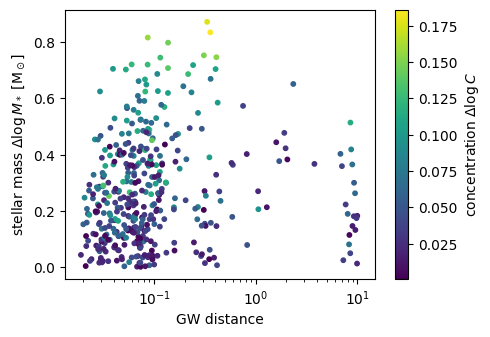

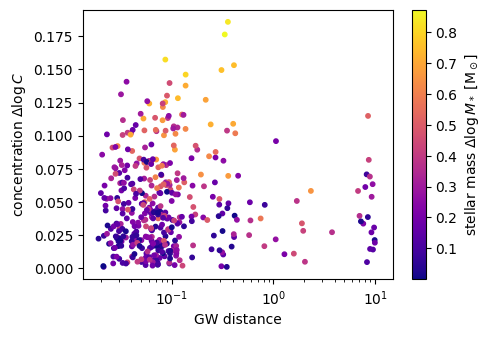

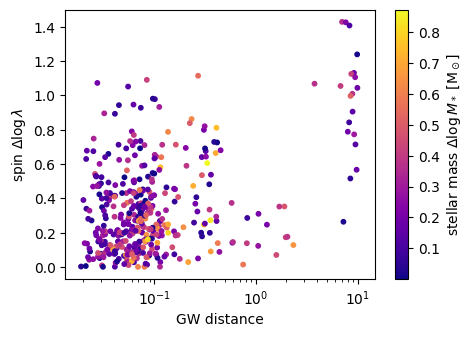

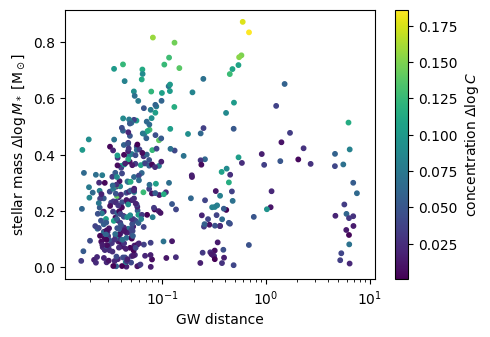

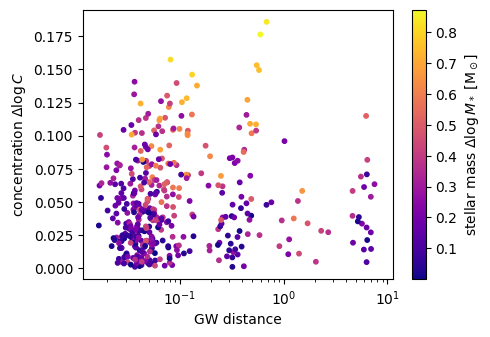

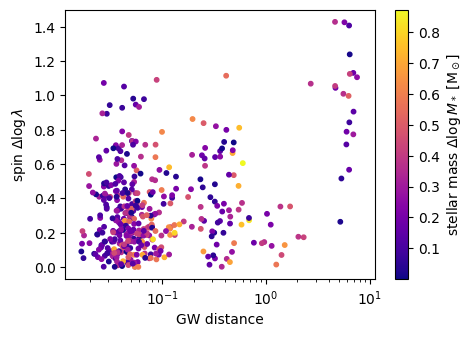

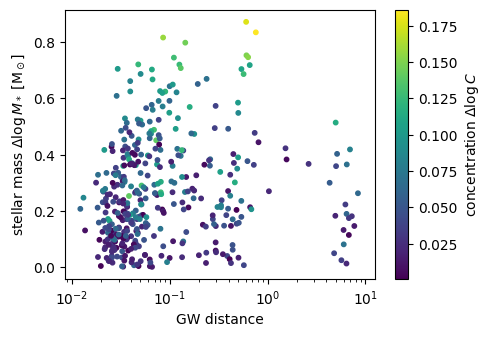

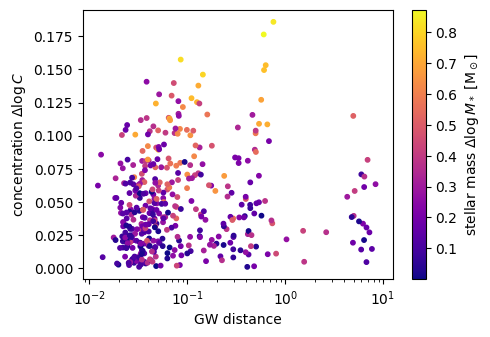

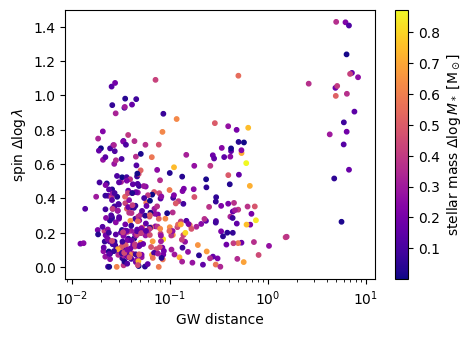

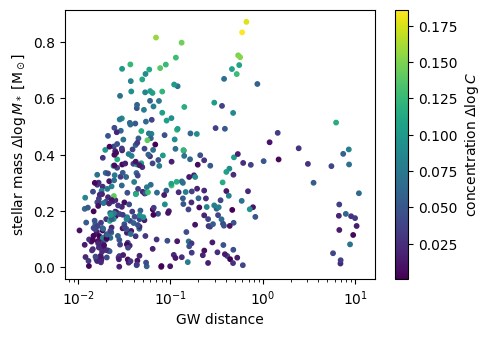

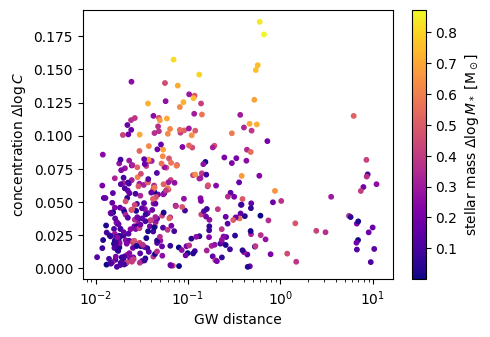

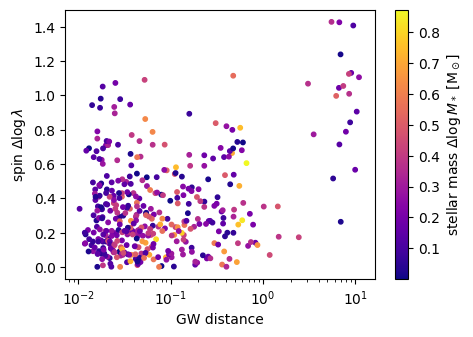

In [94]:
# Plot the correlations between stellar mass, concentration, and halo spin with the GW distance
# to understand if galaxies know about DM halo shapes and how the parametric measures capture
# the shape information. Here we also vary the number of sampled points to check convergence

path = '/content/drive/MyDrive/Colab Notebooks/PointClouds/'

a_size = 20
b_size = 20
num_points = [50, 100, 200, 1000]
v_scales = [8, ]
epsilons = [0.001, ]
iterations = [20, ] # experiments suggest that 20 is okay, it'd be nice to see if it converged


vectorized_dist_function_single_loop = jax.jit(vmap(dist_function, (0, 0, None, 0, 0), 0))
inner_loop = vmap(dist_function, (None, 0, None, None, 0), 0)
vectorized_dist_function_double_loop = jax.jit(vmap(inner_loop, (0, None, None, None, 0), 0))

for n in num_points:
    for eps in epsilons:
        for v in v_scales:
            for it in iterations:
                experiments(a_size, b_size, n, v, eps, it, path, save=False)

In [41]:
np.load('/content/drive/MyDrive/Colab Notebooks/PointClouds/gw_numpoints1000_epsilon0.001_vscale8_iterations20.npy', allow_pickle=True)

array([Array([[0.099013  , 0.01793854, 0.04969878, 0.07370743, 2.602962  ,
               0.0239706 , 0.15969086, 0.01256908, 0.03318702, 0.59068286],
              [0.05213106, 0.01555731, 0.01742572, 0.02692512, 0.8595842 ,
               0.01290113, 0.08690134, 0.01815809, 0.01605931, 0.4573242 ],
              [0.02497151, 0.05062174, 0.02693743, 0.02847733, 0.8641846 ,
               0.03356245, 0.05085113, 0.05266679, 0.03455922, 0.32595608],
              [0.320166  , 0.53932476, 0.41017094, 0.32952148, 0.7455657 ,
               0.4859369 , 0.22552   , 0.5830151 , 0.4600594 , 0.05338224],
              [0.05973137, 0.01902179, 0.02318386, 0.03785516, 0.40967655,
               0.01464608, 0.09760535, 0.02148331, 0.01782467, 0.47131076]],      dtype=float32),
       array([[0.42061234, 0.23791122, 0.27812386, 0.4583168 , 0.422616  ,
               0.05850601, 0.5696764 , 0.11854172, 0.07974911, 0.00651073],
              [0.21083736, 0.02813625, 0.06834888, 0.24854183, 0.2128410

In [44]:
particles, labels, groupid, _, _ = read_data()

In [54]:
np.array(particles)[groupid==6879]

array([{'count': 36990, 'Coordinates': array([[36069.23177501, 59254.73776474, 48295.40687419],
              [36069.02631867, 59254.54929853, 48295.30266859],
              [36069.2257647 , 59254.91040975, 48295.42357784],
              ...,
              [36078.48893102, 59291.00976463, 48202.35789392],
              [36096.25678467, 59226.67363638, 48206.94309632],
              [36048.33019917, 59326.32728968, 48244.32683153]]), 'Velocities': array([[-226.08032 ,  256.7945  , -174.27606 ],
              [-225.273   ,  236.89606 , -166.31512 ],
              [-216.84296 ,  224.11626 , -157.37737 ],
              ...,
              [-162.65057 ,  125.781624, -174.68083 ],
              [-165.35928 ,  130.57664 , -138.98808 ],
              [-202.34203 ,  367.47128 , -228.93025 ]], dtype=float32), 'xs': array([[-1.33761357e-03,  5.42631573e-05, -1.11344520e-02,
               -1.35310517e-02,  9.70389154e-03, -5.35286194e-03],
              [-2.72759992e-03, -1.22077882e-03, -1.183944

In [55]:
np.array(particles)[groupid==6879][0]['xs'][:,0]

array([-0.00133761, -0.0027276 , -0.00137828, ...,  0.06129039,
        0.18149634, -0.14274432])

Text(0, 0.5, '$V_y$')

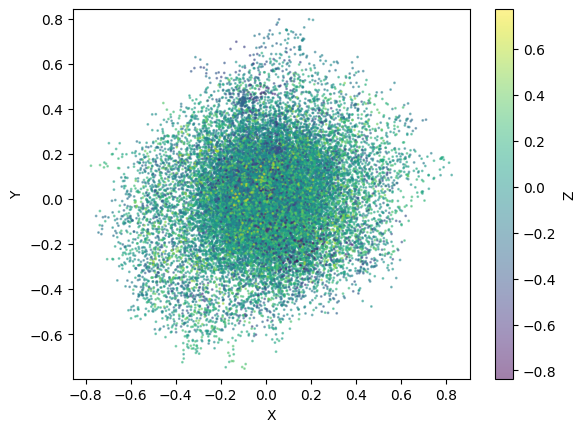

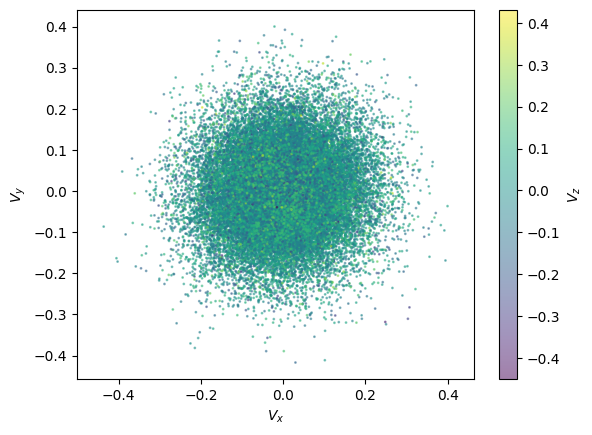

In [63]:
# visualize projected positions and velocities

pos = np.array(particles)[groupid==6879][0]['xs'][:,0:3]
vel = np.array(particles)[groupid==6879][0]['xs'][:,3:]

plt.figure()
plt.scatter(pos[:,0::10], pos[:,1::10],
            s=1, alpha=0.5,
            c=pos[:,2::10])
plt.colorbar(label='Z')
plt.axis('equal')
plt.xlabel('X'); plt.ylabel('Y')

plt.figure()
plt.scatter(vel[:,0::10], vel[:,1::10],
            s=1, alpha=0.5,
            c=vel[:,2::10])
plt.colorbar(label='$V_z$')
plt.axis('equal')
plt.xlabel('$V_x$'); plt.ylabel('$V_y$')

Text(0, 0.5, '$V_y$')

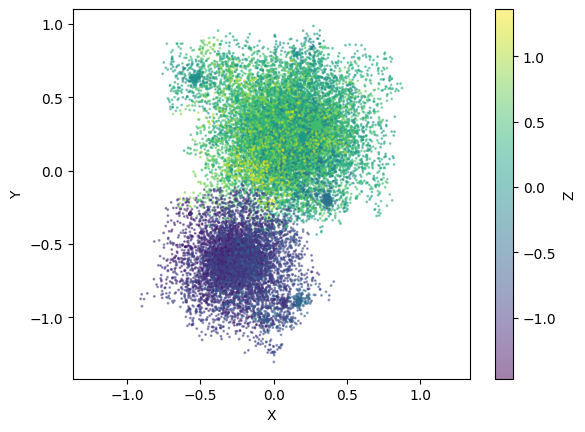

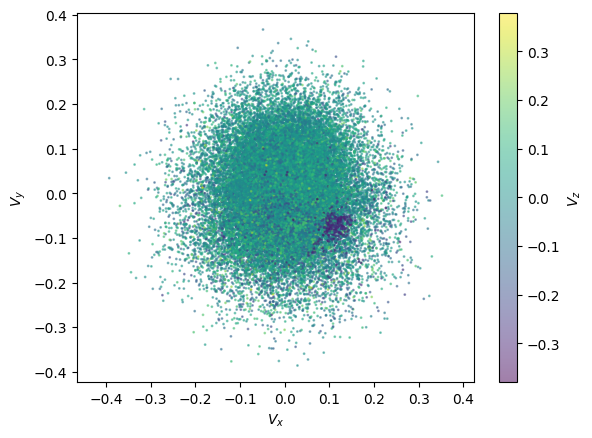

In [64]:
pos = np.array(particles)[groupid==6574][0]['xs'][:,0:3]
vel = np.array(particles)[groupid==6574][0]['xs'][:,3:]

plt.figure()
plt.scatter(pos[:,0::10], pos[:,1::10],
            s=1, alpha=0.5,
            c=pos[:,2::10])
plt.colorbar(label='Z')
plt.axis('equal')
plt.xlabel('X'); plt.ylabel('Y')

plt.figure()
plt.scatter(vel[:,0::10], vel[:,1::10],
            s=1, alpha=0.5,
            c=vel[:,2::10])
plt.colorbar(label='$V_z$')
plt.axis('equal')
plt.xlabel('$V_x$'); plt.ylabel('$V_y$')

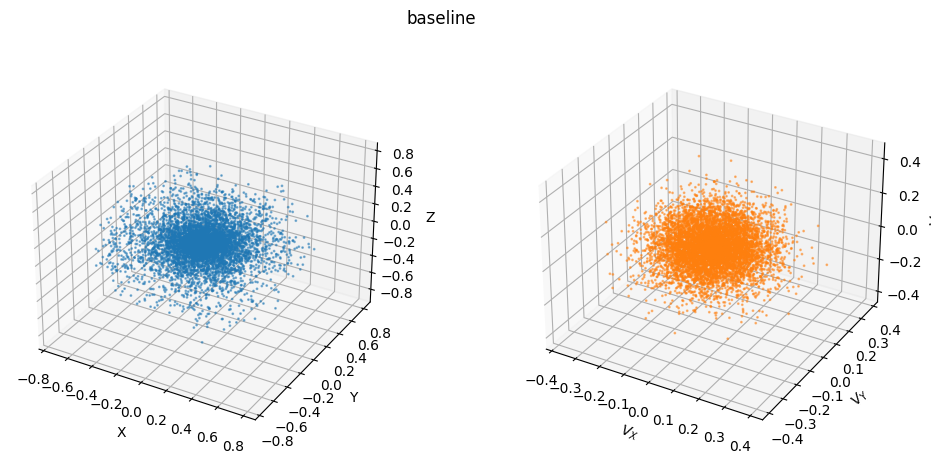

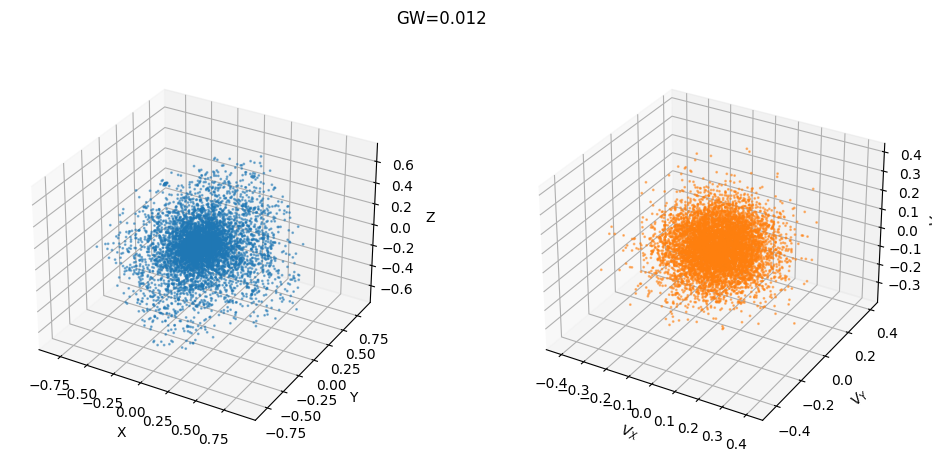

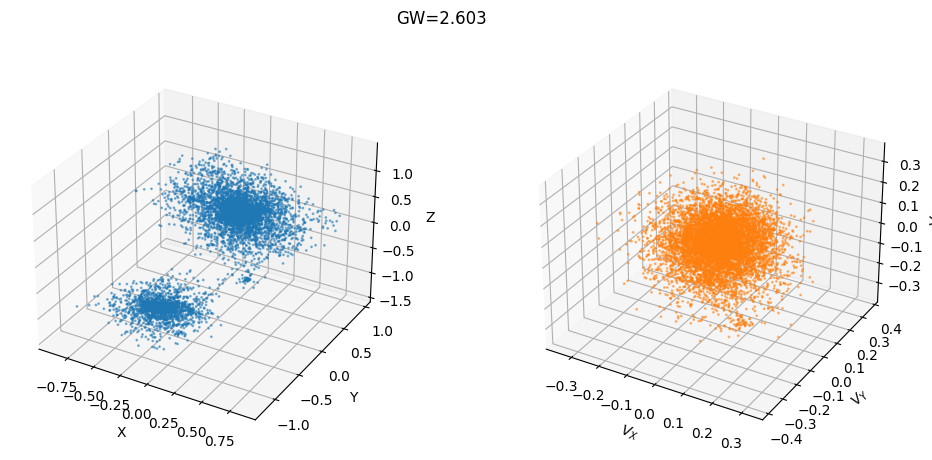

In [93]:
# compare the two most similar and the two most distant haloes (by GW distance)

step=5

for id, title in zip([6879,6695,6574],['baseline','GW=0.012','GW=2.603']):

  pos = np.array(particles)[groupid==id][0]['xs'][:,0:3]
  vel = np.array(particles)[groupid==id][0]['xs'][:,3:]

  fig = plt.figure(figsize=(12,5))

  ax = fig.add_subplot(121, projection='3d')
  ax.scatter(pos[::step,0], pos[::step,1], pos[::step,2],
              s=1, alpha=0.5)
  ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')

  ax = fig.add_subplot(122, projection='3d')
  ax.scatter(vel[::step,0], vel[::step,1], vel[::step,2],
              s=1, alpha=0.5, c='C1')
  ax.set_xlabel('$V_X$'); ax.set_ylabel('$V_Y$'); ax.set_zlabel('$V_Z$')
  plt.suptitle(title, fontsize='large')

  plt.savefig(path+"plot_{}.pdf".format(title), bbox_inches='tight')


Text(0.5, 0.98, 'GW=0.859')

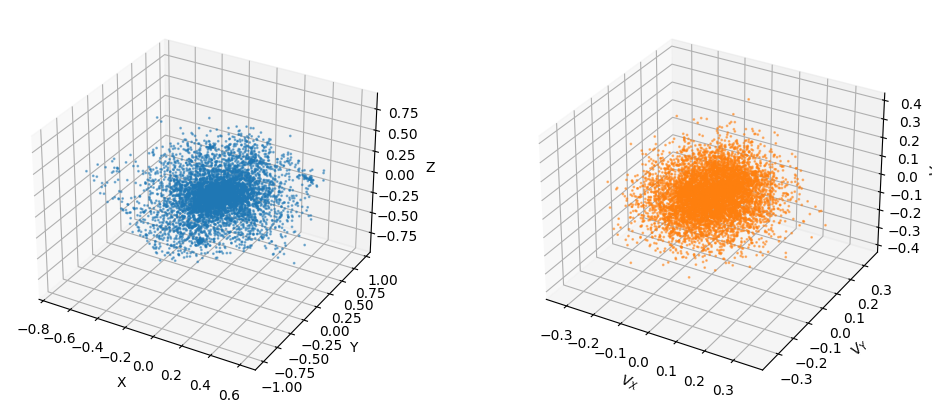

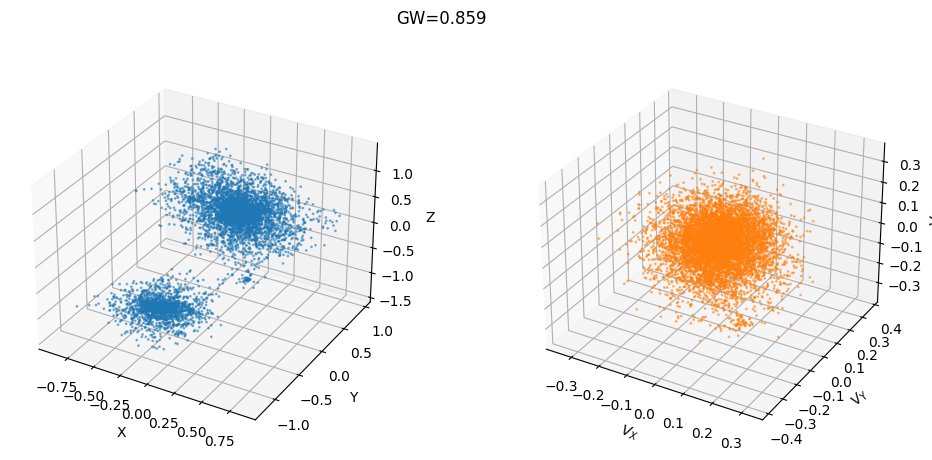

In [82]:
# compare another pair of distant haloes

step=5

for id in [6373,6574]:

  pos = np.array(particles)[groupid==id][0]['xs'][:,0:3]
  vel = np.array(particles)[groupid==id][0]['xs'][:,3:]

  fig = plt.figure(figsize=(12,5))

  ax = fig.add_subplot(121, projection='3d')
  ax.scatter(pos[::step,0], pos[::step,1], pos[::step,2],
              s=1, alpha=0.5)
  ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')

  ax = fig.add_subplot(122, projection='3d')
  ax.scatter(vel[::step,0], vel[::step,1], vel[::step,2],
              s=1, alpha=0.5, c='C1')
  ax.set_xlabel('$V_X$'); ax.set_ylabel('$V_Y$'); ax.set_zlabel('$V_Z$')

  fig.suptitle('GW=0.859')

In [ ]:
# compare 6D distirbution of first ten haloes in catalog

for ihalo in range(10):

  fig = plt.figure(figsize=(12,5))

  ax = fig.add_subplot(121, projection='3d')

  xpos = particles[ihalo]['Coordinates'][:,0]
  ypos = particles[ihalo]['Coordinates'][:,1]
  zpos = particles[ihalo]['Coordinates'][:,2]
  rad = np.sqrt( (xpos-np.mean(xpos))**2 + (ypos-np.mean(ypos))**2 + (zpos-np.mean(zpos))**2 )

  vx = particles[ihalo]['Velocities'][:,0]
  vy = particles[ihalo]['Velocities'][:,1]
  vz = particles[ihalo]['Velocities'][:,2]
  vtot = np.sqrt( (vx-np.mean(vx))**2 + (vy-np.mean(vy))**2 + (vz-np.mean(vz))**2 )

  ax.scatter(xpos-np.mean(xpos), ypos-np.mean(ypos), zpos-np.mean(zpos),
             c=vtot,
             cmap='plasma',
             s=1)
  ax.set_xlabel('X [kpc]')
  ax.set_ylabel('Y [kpc]')
  ax.set_zlabel('Z [kpc]')

  ax2 = fig.add_subplot(122, projection='3d')

  ax2.scatter(vx-np.mean(vx), vy-np.mean(vy), vz-np.mean(vz),
              c=rad,
              cmap='viridis',
              s=1)
  ax2.set_xlabel('Vx [km/s]')
  ax2.set_ylabel('Vy [km/s]')
  ax2.set_zlabel('Vz [km/s]')

  plt.subplots_adjust(wspace=0.3)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for ihalo in range(10):

  fig = plt.figure(figsize=(12,5))

  ax = fig.add_subplot(121, projection='3d')

  w1 = particles[ihalo]['xs'][:,0]
  w2 = particles[ihalo]['xs'][:,1]
  w3 = particles[ihalo]['xs'][:,2]
  w4 = particles[ihalo]['xs'][:,3]
  w5 = particles[ihalo]['xs'][:,4]
  w6 = particles[ihalo]['xs'][:,5]

  ax.scatter(w1, w2, w3,  s=1)
  ax.set_xlabel('w1')
  ax.set_ylabel('w2')
  ax.set_zlabel('w3')

  ax2 = fig.add_subplot(122, projection='3d')

  ax2.scatter(w4, w5, w6, s=1)
  ax2.set_xlabel('w4')
  ax2.set_ylabel('w5')
  ax2.set_zlabel('w6')

  plt.subplots_adjust(wspace=0.3)

Output hidden; open in https://colab.research.google.com to view.